In [487]:
import numpy as np
import pandas as pd

In [488]:
meteo = pd.read_csv('open-meteo-45.31N39.66E80m.csv')
meteo['time'] = pd.to_datetime(meteo['time'])
meteo.set_index('time', inplace=True)
monthly_weather = meteo.resample('M').mean()
monthly_weather['month'] = pd.date_range(start='2016-01-01', periods=96, freq='MS')
monthly_weather.set_index('month', inplace=True)

In [489]:
data = [
    ['2016', '221', 'Кук/зерно (Ладожская МВ)', 'нет', 'нет', '60'],
    ['2016', '226', 'Оз.пшеница (сем. Васса)', 'нет', 'Диаммофоска 10:26:26 – 150кг/га, Аммофос (12:52) – 40кг/га, Ам.селитра – 100кг/га', '57.3'],
    ['2017', '221', 'Соя (Арлета)', 'Кук/зерно (Ладожская МВ)', 'нет', '17.2'],
    ['2017', '226', 'Оз.ячмень (Самсон)', 'Оз.пшеница (сем. Васса)', 'Ам.селитра – 100кг/га, Аммофос - 40, Ам.селитра – 100кг/га', '47.4'],
    ['2018', '221', 'Оз.пшеница (Стан)', 'Соя (Арлета)', 'Диаммофоска 10:26:26 – 150кг/га, Аммофос (12:52) – 50кг/га, Ам.селитра – 200кг/га', '74.2'],
    ['2018', '226', 'Сах.свекла (Талтос)', 'Оз.ячмень (Самсон)', 'Аммофос – 200кг/га, Карбамид – 200кг/га, Калий хлористый – 200кг/га', '291.7'],
    ['2019', '221', 'Сах.свекла (Крокодил)', 'Оз.пшеница (Стан)', 'Аммофос – 200кг/га, Карбамид – 200кг/га, Калий хлористый – 200кг/га', '618.9'],
    ['2019', '226', 'Оз.пшеница (Гурт)', 'Сах.свекла (Талтос)', 'Ам.селитра – 100кг/га, Диаммофоска 10:26:26 – 150кг/га, Ам.селитра – 100кг/га', '69'],
    ['2020', '221', 'Оз.пшеница (Юка)', 'Сах.свекла (Крокодил)', 'Ам.селитра – 100кг/га, Диаммофоска 10:26:26 – 200 кг/га, Ам.селитра – 100кг/га', '51.7'],
    ['2020', '226', 'Кук/гибр', 'Оз.пшеница (Гурт)', 'нет', np.nan],
    ['2021', '221', 'Кук/гибр', 'Оз.пшеница (Юка)', 'нет', np.nan],
    ['2021', '226', 'Соя (Оптима)', 'Кук/гибр', 'нет', '17'],
    ['2022', '221', 'Оз.пшеница (Юка)', 'Кук/гибр', 'Ам.селитра – 100кг/га, Тукосмесь 10:25:20 – 200кг/га, Ам.селитра – 300кг/га', '72.6'],
    ['2022', '226', 'Оз.пшеница (Алексеич семенная)', 'Соя (Оптима)', 'Тукосмесь 10:25:20 – 200кг/га, Ам.селитра – 200кг/га', '83.3'],
    ['2023', '221', 'Кук/гибр', 'Оз.пшеница (Юка)', 'нет', '47.7'],
    ['2023', '226', 'Кук/гибр', 'Оз.пшеница (Алексеич семенная)', 'навоз – 15га – 30т/га', '44.3']
]
df = pd.DataFrame(data, columns=['ГОД', '№ поля', 'Культура (Сорт/Гибрид)', 'Предыдущая культура', 'Наименование Удобрений', 'Урожайность'])
df['ГОД'] = df['ГОД'].astype(int)
df['Урожайность'] = df['Урожайность'].astype(float)
df['date'] = df['ГОД'].apply(lambda x: pd.date_range(start=f"{x-1}-09-01", periods=12, freq='MS'))

df = df.explode('date').reset_index(drop=True)
df.set_index('date', inplace=True)


In [490]:
merged_data = monthly_weather.merge(df, left_index=True, right_index=True, how='left').iloc[:-4].fillna(47.7).drop('ГОД', axis=1)
merged_data[['№ поля']] = merged_data[['№ поля']].astype('int64')

In [491]:
merged_data.dtypes

temperature_2m (°C)               float64
relative_humidity_2m (%)          float64
dew_point_2m (°C)                 float64
apparent_temperature (°C)         float64
precipitation (mm)                float64
rain (mm)                         float64
snowfall (cm)                     float64
snow_depth (m)                    float64
weather_code (wmo code)           float64
pressure_msl (hPa)                float64
surface_pressure (hPa)            float64
cloud_cover (%)                   float64
cloud_cover_mid (%)               float64
vapour_pressure_deficit (kPa)     float64
wind_speed_10m (km/h)             float64
soil_temperature_0_to_7cm (°C)    float64
№ поля                              int64
Культура (Сорт/Гибрид)             object
Предыдущая культура                object
Наименование Удобрений             object
Урожайность                       float64
dtype: object

In [492]:
merged_data_first = merged_data[merged_data['№ поля'] == 221].drop('№ поля', axis=1)
merged_data_second = merged_data[merged_data['№ поля'] == 226].drop('№ поля', axis=1)
merged_data = pd.concat([merged_data_first, merged_data_second], ignore_index=True)


In [493]:
merged_data

,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),weather_code (wmo code),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_mid (%),vapour_pressure_deficit (kPa),wind_speed_10m (km/h),soil_temperature_0_to_7cm (°C),Культура (Сорт/Гибрид),Предыдущая культура,Наименование Удобрений,Урожайность
0,-0.963575,82.319892,-3.738172,-5.383871,0.112097,0.092339,0.017876,0.047473,18.626344,1017.329570,1007.167473,73.737903,53.194892,0.120497,13.618683,2.166263,Кук/зерно (Ладожская МВ),нет,нет,60.0
1,5.569397,74.968391,1.106897,1.693391,0.064224,0.044253,0.014282,0.007414,8.676724,1020.264368,1010.314224,48.919540,28.339080,0.269828,14.042385,5.432184,Кук/зерно (Ладожская МВ),нет,нет,60.0
2,7.287097,73.657258,2.527016,3.516398,0.070833,0.070833,0.000470,0.000000,10.040323,1014.086290,1004.258333,61.129032,38.920699,0.301815,14.850134,7.904973,Кук/зерно (Ладожская МВ),нет,нет,60.0
3,13.434028,65.365278,6.482639,10.693056,0.043194,0.043194,0.000000,0.000000,5.752778,1013.328056,1003.716111,37.662500,28.134722,0.615292,14.171667,13.489444,Кук/зерно (Ладожская МВ),нет,нет,60.0
4,16.509946,74.188172,11.489919,15.509140,0.127151,0.127151,0.000000,0.000000,11.413978,1011.745968,1002.251075,45.389785,29.354839,0.538965,11.273656,16.799597,Кук/зерно (Ладожская МВ),нет,нет,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,12.034306,76.698611,7.780556,9.364028,0.137778,0.137778,0.000000,0.000000,15.708333,1012.257361,1002.606667,55.663889,42.855556,0.361236,15.241250,12.214861,Кук/гибр,Оз.пшеница (Алексеич семенная),навоз – 15га – 30т/га,44.3
180,15.952688,75.553763,11.229301,14.807796,0.137903,0.137903,0.000000,0.000000,10.883065,1015.669758,1006.117473,46.740591,30.473118,0.506599,12.329167,16.123522,Кук/гибр,Оз.пшеница (Алексеич семенная),навоз – 15га – 30т/га,44.3
181,20.752500,72.715278,15.215972,21.088889,0.128889,0.128889,0.000000,0.000000,9.875000,1011.529583,1002.175139,35.441667,16.815278,0.745083,11.863472,21.223611,Кук/гибр,Оз.пшеница (Алексеич семенная),навоз – 15га – 30т/га,44.3
182,23.684812,66.623656,16.455376,24.440054,0.106720,0.106720,0.000000,0.000000,7.400538,1011.018548,1001.758737,17.747312,11.212366,1.120685,12.365323,24.251613,Кук/гибр,Оз.пшеница (Алексеич семенная),навоз – 15га – 30т/га,44.3


In [494]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
cat_cols = ['Культура (Сорт/Гибрид)', 'Наименование Удобрений', 'Предыдущая культура']
num_cols = [col for col in merged_data.columns if col not in cat_cols and col not in ['№ поля', 'Урожайность']]
scaler = StandardScaler()
le = LabelEncoder()
merged_data[num_cols] = scaler.fit_transform(merged_data[num_cols])
label_encoders = {}
for column in cat_cols:
    le = LabelEncoder()
    merged_data[column] = le.fit_transform(merged_data[column])
    label_encoders[column] = le


c:\Python\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Python\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Python\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Python\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_spa

In [495]:
sequence_length = 12  
features = []
targets = []

for i in range(len(merged_data) - sequence_length):
    features.append(merged_data.iloc[i:i+sequence_length].drop('Урожайность', axis=1).values)
    targets.append(merged_data.iloc[i+sequence_length]['Урожайность'])

features = np.array(features, dtype='float64')
targets = np.array(targets)


In [496]:
targets.shape

(172,)

In [497]:
features.shape

(172, 12, 19)

In [498]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

n_samples = 172
time_steps = 12
n_features = 19

model = Sequential([
    LSTM(64, activation='relu', input_shape=(time_steps, n_features)), 
    Dense(1)
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=30)


history = model.fit(
    features, targets,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Epoch 1/100
5/5 [==============================] - 1s 42ms/step - loss: 122.7358 - mae: 122.7358 - val_loss: 44.1714 - val_mae: 44.1714
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 116.2613 - mae: 116.2613 - val_loss: 31.3886 - val_mae: 31.3886
Epoch 3/100
5/5 [==============================] - 0s 10ms/step - loss: 96.1920 - mae: 96.1920 - val_loss: 45.1594 - val_mae: 45.1594
Epoch 4/100
5/5 [==============================] - 0s 10ms/step - loss: 88.6241 - mae: 88.6241 - val_loss: 22.5034 - val_mae: 22.5034
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 80.8622 - mae: 80.8622 - val_loss: 23.8128 - val_mae: 23.8128
Epoch 6/100
5/5 [==============================] - 0s 10ms/step - loss: 79.8874 - mae: 79.8874 - val_loss: 23.4835 - val_mae: 23.4835
Epoch 7/100
5/5 [==============================] - 0s 9ms/step - loss: 79.1918 - mae: 79.1918 - val_loss: 24.4880 - val_mae: 24.4880
Epoch 8/100
5/5 [==============================] - 0s 9ms/s

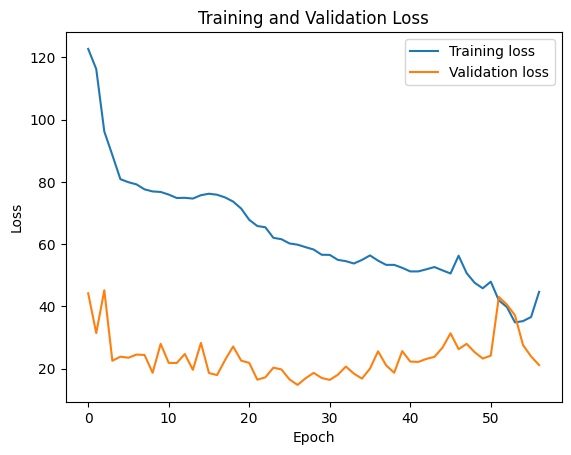

In [499]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [502]:
preds = model.predict(features)
from sklearn.metrics import mean_absolute_error
mean_absolute_error(preds, targets)

6/6 [==============================] - 0s 2ms/step


44.27004510746446

In [501]:
preds

array([[ 19.42683 ],
       [ 18.352509],
       [ 21.526329],
       [ 21.073982],
       [ 16.49244 ],
       [ 19.705194],
       [ 21.098042],
       [ 24.700897],
       [ 72.570526],
       [ 75.06335 ],
       [ 76.99055 ],
       [ 77.15148 ],
       [ 78.29601 ],
       [ 78.53082 ],
       [ 77.884155],
       [ 77.0811  ],
       [ 74.08488 ],
       [ 73.856094],
       [ 73.207504],
       [ 72.65684 ],
       [ 73.96252 ],
       [ 73.78803 ],
       [ 70.14132 ],
       [ 60.276848],
       [ 52.877983],
       [ 51.72627 ],
       [ 64.58816 ],
       [140.51875 ],
       [263.3301  ],
       [405.65457 ],
       [134.40855 ],
       [ 75.87504 ],
       [ 58.6752  ],
       [ 59.849792],
       [ 57.221733],
       [ 54.559025],
       [ 53.106323],
       [ 51.90194 ],
       [ 51.6113  ],
       [ 49.912735],
       [ 48.394043],
       [ 49.95395 ],
       [ 49.863792],
       [ 51.388947],
       [ 48.710808],
       [ 48.948963],
       [ 48.646343],
       [ 46.0